In [117]:
#
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("PyTorch版本:", torch.__version__)
print("TorchVision版本:", torchvision.__version__)

PyTorch版本: 2.5.1
TorchVision版本: 0.20.1


In [118]:
# 数据预处理
transform_train=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
print("数据预处理定义完成")


数据预处理定义完成


In [119]:
class LeafDataset(Dataset):
    def __init__(self,images_path,labels,transform=None):
        self.images_path=images_path
        self.labels=labels
        self.transform=transform
    
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx=idx.tolist()
        #读取图片
        img_path=self.images_path[idx]
        img=Image.open(img_path).convert('RGB')
        label=self.labels[idx]
        
        if self.transform:
            img=self.transform(img)
            
        return img,label
print("LeafDataset is ready")

LeafDataset is ready


In [120]:
train_dataframe=pd.read_csv('train.csv')
print("train_dataframe is ready")
print(train_dataframe.head())
print(train_dataframe['label'].nunique())


train_dataframe is ready
          image             label
0  images/0.jpg  maclura_pomifera
1  images/1.jpg  maclura_pomifera
2  images/2.jpg  maclura_pomifera
3  images/3.jpg  maclura_pomifera
4  images/4.jpg  maclura_pomifera
176


In [121]:
def create_label_mapping(labels):
    unique_labels=sorted(list(set(labels)))
    label_to_idx={label:idx for idx,label in enumerate(unique_labels)}
    idx_to_label={idx:label for label,idx in label_to_idx.items()}
    return label_to_idx,idx_to_label
    
label_to_idx,idx_to_label=create_label_mapping(train_dataframe['label'])
num_classes=len(label_to_idx)
print(num_classes)
for i in range(num_classes):
    print(idx_to_label[i])

176
abies_concolor
abies_nordmanniana
acer_campestre
acer_ginnala
acer_griseum
acer_negundo
acer_palmatum
acer_pensylvanicum
acer_platanoides
acer_pseudoplatanus
acer_rubrum
acer_saccharinum
acer_saccharum
aesculus_flava
aesculus_glabra
aesculus_hippocastamon
aesculus_pavi
ailanthus_altissima
albizia_julibrissin
amelanchier_arborea
amelanchier_canadensis
amelanchier_laevis
asimina_triloba
betula_alleghaniensis
betula_jacqemontii
betula_lenta
betula_nigra
betula_populifolia
broussonettia_papyrifera
carpinus_betulus
carpinus_caroliniana
carya_cordiformis
carya_glabra
carya_ovata
carya_tomentosa
castanea_dentata
catalpa_bignonioides
catalpa_speciosa
cedrus_atlantica
cedrus_deodara
cedrus_libani
celtis_occidentalis
celtis_tenuifolia
cercidiphyllum_japonicum
cercis_canadensis
chamaecyparis_pisifera
chamaecyparis_thyoides
chionanthus_retusus
chionanthus_virginicus
cladrastis_lutea
cornus_florida
cornus_kousa
cornus_mas
crataegus_crus-galli
crataegus_laevigata
crataegus_phaenopyrum
crataegus_

In [122]:
#划分训练集和验证集
def split_data(images_path,labels,test_size=0.2,random_state=42):
    train_images,val_images,train_labels,val_labels=train_test_split(images_path,labels,test_size=test_size,random_state=random_state)
    return train_images,val_images,train_labels,val_labels
images_path=train_dataframe['image'].tolist()
labels=train_dataframe['label'].tolist()
labels=[label_to_idx[label] for label in labels]

train_images,val_images,train_labels,val_labels=split_data(images_path,labels)
print(len(train_images),len(val_images))
print(train_images[0],idx_to_label[train_labels[0]])
print(val_images[0],idx_to_label[val_labels[0]])

14682 3671
images/4219.jpg cedrus_libani
images/16892.jpg quercus_imbricaria


In [123]:
#创建数据加载器
def create_train_data_loaders(train_images,train_labels,val_images,val_labels,batch_size=32):
    train_dataset=LeafDataset(train_images,train_labels,transform=transform_train)
    val_dataset=LeafDataset(val_images,val_labels,transform=transform_train)
    
    #完成数据加载器的定义
    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
    return train_loader,val_loader
#创建模型
train_data_loader,val_data_loader=create_train_data_loaders(train_images,train_labels,val_images,val_labels)
print(len(train_data_loader))
print(len(val_data_loader))

459
115


In [124]:
#完成模型框架的定义
class LeafClassifier(torch.nn.Module):
    def __init__(self,num_classes,model_name='resnet50'):
        super(LeafClassifier,self).__init__()
        if model_name == 'resnet50':
            self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
            num_features=2048
        elif model_name == 'resnet18':
            self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
            num_features=512
        elif model_name == 'resnet34':
            self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
            num_features=512
        else:  
            self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
            num_features=2048
        self.model.fc = torch.nn.Linear(num_features,num_classes)
        
    def forward(self,x):
        x = self.model(x)
        return x
    
print('LeafClassifier model is ready')


LeafClassifier model is ready


In [125]:
#完成每一个epoch的训练
def train_one_epoch(model,train_loader,criterion,optimizer,device):
    model.train()
    running_loss=0.0
    correct=0.0
    total=0
    for batch_idx,(inputs,labels) in enumerate(train_loader):
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        _,predicted=outputs.max(1)
        total+=labels.size(0)
        correct+=predicted.eq(labels).sum().item()
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f} - Accuracy: {correct/total:.4f}")
    epoch_loss=running_loss/len(train_loader)
    epoch_acc=correct/total
    return epoch_loss,epoch_acc


In [126]:
#完成验证模型的编写
def validate(model,val_data_loader,criterion,device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs,labels in val_data_loader:
            inputs,labels=inputs.to(device),labels.to(device)
            outputs = model(inputs)
            loss=criterion(outputs,labels)
            
            running_loss += loss.item()
            _,predicted = torch.max(outputs.data,dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = running_loss / len(val_data_loader)
    val_acc = correct / total
    return val_loss,val_acc
print("训练以及验证函数编写完毕")

训练以及验证函数编写完毕


In [127]:
def train_model(model,train_data_loader,val_data_loader,criterion,optimizer,device,num_epochs=10):
    print("使用设备：{}".format(device))
    model=model.to(device)
    
    criterion=criterion.to(device)
    
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)
    
    #记录训练历史
    train_losses,train_accs=[],[]
    val_losses,val_accs=[],[]
    
    print("开始训练")
    for epoch in range(num_epochs):
        print("第{}轮训练开始".format(epoch+1))
        train_loss,train_acc=train_one_epoch(model,train_data_loader,criterion,optimizer,device)
        val_loss,val_acc=validate(model,val_data_loader,criterion,device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        scheduler.step()
        
    return model,{"train_losses":train_losses,"train_accs":train_accs,"val_losses":val_losses,"val_accs":val_accs}


print("训练的主函数完成")

        


训练的主函数完成


In [128]:
# 第11步：可视化训练过程
def plot_training_history(history):
    """绘制训练历史"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 绘制损失
    ax1.plot(history['train_losses'], label='训练损失')
    ax1.plot(history['val_losses'], label='验证损失')
    ax1.set_title('模型损失')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # 绘制准确率
    ax2.plot(history['train_accs'], label='训练准确率')  # 修改为 'train_accs'
    ax2.plot(history['val_accs'], label='验证准确率')    # 修改为 'val_accs'
    ax2.set_title('模型准确率')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

print("可视化函数定义完成")

可视化函数定义完成


In [129]:
#完成实际的训练过程
model=LeafClassifier(num_classes=176,model_name='resnet34')
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.0001)
#训练模型
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model,history=train_model(model,train_data_loader=train_data_loader,val_data_loader=val_data_loader,criterion=criterion,optimizer=optimizer,device=device,num_epochs=10)





Using cache found in C:\Users\王旭帆/.cache\torch\hub\pytorch_vision_v0.10.0


使用设备：cuda
开始训练
第1轮训练开始
Batch 0/459 - Loss: 5.2828 - Accuracy: 0.0312
Batch 10/459 - Loss: 5.1505 - Accuracy: 0.0199
Batch 20/459 - Loss: 5.1590 - Accuracy: 0.0342
Batch 30/459 - Loss: 4.5590 - Accuracy: 0.0494
Batch 40/459 - Loss: 4.7205 - Accuracy: 0.0595
Batch 50/459 - Loss: 4.0659 - Accuracy: 0.0833
Batch 60/459 - Loss: 4.0096 - Accuracy: 0.0963
Batch 70/459 - Loss: 3.7217 - Accuracy: 0.1105
Batch 80/459 - Loss: 3.5351 - Accuracy: 0.1277
Batch 90/459 - Loss: 3.7190 - Accuracy: 0.1387
Batch 100/459 - Loss: 3.2591 - Accuracy: 0.1550
Batch 110/459 - Loss: 3.0914 - Accuracy: 0.1669
Batch 120/459 - Loss: 3.2727 - Accuracy: 0.1782
Batch 130/459 - Loss: 3.0446 - Accuracy: 0.1918
Batch 140/459 - Loss: 2.9153 - Accuracy: 0.2061
Batch 150/459 - Loss: 2.9219 - Accuracy: 0.2185
Batch 160/459 - Loss: 2.4476 - Accuracy: 0.2277
Batch 170/459 - Loss: 2.9816 - Accuracy: 0.2392
Batch 180/459 - Loss: 2.4763 - Accuracy: 0.2484
Batch 190/459 - Loss: 2.9725 - Accuracy: 0.2569
Batch 200/459 - Loss: 2.5499

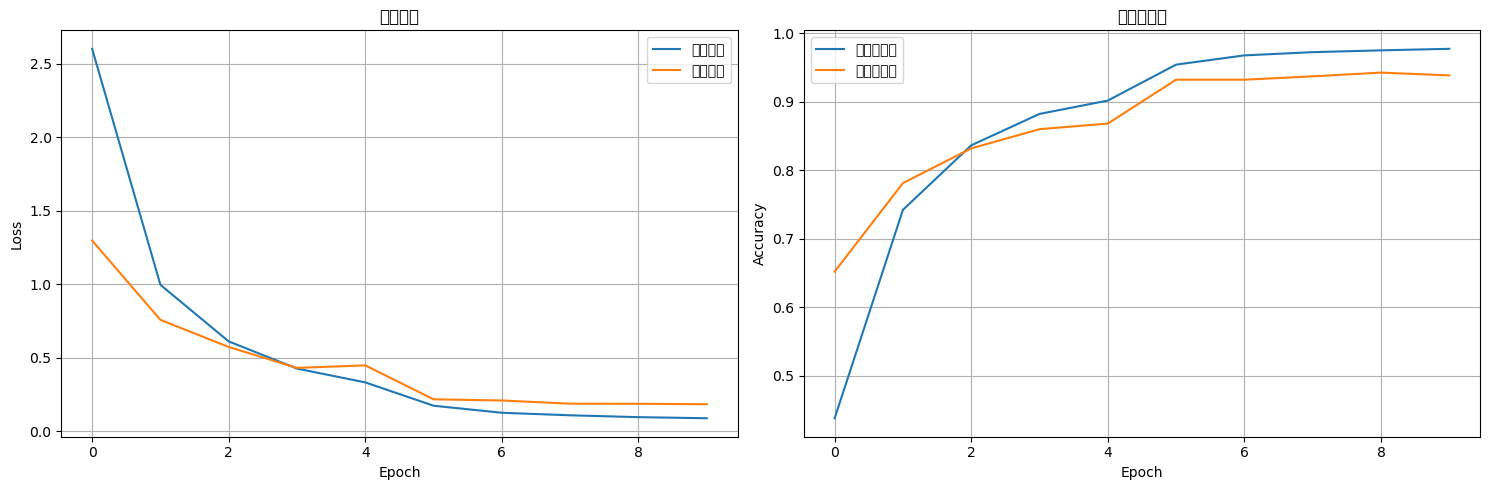

{'train_losses': [2.60131536070298, 0.9950081397635225, 0.6099390858918233, 0.4252145553174102, 0.33116889540471284, 0.17237887636622443, 0.12454342825869849, 0.10730623727773919, 0.09476585323822914, 0.08725334504671996], 'train_accs': [0.4381555646369704, 0.7422694455796213, 0.8363983108568315, 0.8822367524860373, 0.901716387413159, 0.9541615583707942, 0.9676474594741861, 0.9723470916768833, 0.9750034055305816, 0.9772510557144803], 'val_losses': [1.2963561322378077, 0.7568366519782854, 0.5723245255325151, 0.43005901367767996, 0.44693403542041776, 0.2161732888740042, 0.20810465662051802, 0.18635910927601482, 0.18583543990617213, 0.18255652974805106], 'val_accs': [0.6521383819122855, 0.7812585126668483, 0.8319259057477526, 0.8599836556796513, 0.8681558158539907, 0.9321710705529829, 0.9321710705529829, 0.9370743666575865, 0.9425224734404795, 0.9384363933533098]}


In [130]:
#可视化训练过程
plot_training_history(history)
print(history)

In [131]:
# 第13步：预测函数
def predict(model, data_loader, device):
    """对数据进行预测"""
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs,labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            if isinstance(labels, torch.Tensor):
                true_labels.extend(labels.cpu().numpy())
            else:
                # 如果 labels 是元组或其他类型，需要先转换为张量
                true_labels.extend(torch.tensor(labels).cpu().numpy())

    return predictions,true_labels


print("预测函数定义完成")


预测函数定义完成


In [135]:
#完成测试数据集的加载
import pandas as pd
test_dataframe=pd.read_csv('sample_submission.csv')
#使用label_to_idx 完成数据集的标签的转换
test_labels=test_dataframe['label']
test_labels=[0]*len(test_labels)
test_images=test_dataframe['image']
#完成测试数据加载器的创建
test_dataset=LeafDataset(test_images,test_labels,transform=transform_test)

test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

#完成预测函数的应用
predictions,true_labels=predict(model,test_loader,device)


In [145]:
print(predictions)
print('*'*100)

print(true_labels)
print('*'*100)
predictions=pd.Series(predictions)

#使用idx_to_label进行转换
predictions_labels=predictions.map(idx_to_label)
test_dataframe['label']=predictions_labels
print(test_dataframe)
test_dataframe.to_csv('sample_submission.csv',index=False)

print(idx_to_label)
print(label_to_idx)

0        22
1       121
2       120
3       102
4       120
       ... 
8795    117
8796     53
8797    117
8798     73
8799     73
Length: 8800, dtype: int64
****************************************************************************************************
[0 0 0 ... 0 0 0]
****************************************************************************************************
                 image                  label
0     images/18353.jpg        asimina_triloba
1     images/18354.jpg  platanus_occidentalis
2     images/18355.jpg    platanus_acerifolia
3     images/18356.jpg         pinus_bungeana
4     images/18357.jpg    platanus_acerifolia
...                ...                    ...
8795  images/27148.jpg       pinus_thunbergii
8796  images/27149.jpg   crataegus_crus-galli
8797  images/27150.jpg       pinus_thunbergii
8798  images/27151.jpg   juniperus_virginiana
8799  images/27152.jpg   juniperus_virginiana

[8800 rows x 2 columns]
{0: 'abies_concolor', 1: 'abies_nordmanniana

In [142]:
print(predictions_labels)

0             asimina_triloba
1       platanus_occidentalis
2         platanus_acerifolia
3              pinus_bungeana
4         platanus_acerifolia
                ...          
8795         pinus_thunbergii
8796     crataegus_crus-galli
8797         pinus_thunbergii
8798     juniperus_virginiana
8799     juniperus_virginiana
Length: 8800, dtype: object


评估函数定义完成
                              precision    recall  f1-score   support

              abies_concolor       1.00      0.01      0.01      8800
          abies_nordmanniana       0.00      0.00      0.00         0
              acer_campestre       0.00      0.00      0.00         0
                acer_ginnala       0.00      0.00      0.00         0
                acer_griseum       0.00      0.00      0.00         0
                acer_negundo       0.00      0.00      0.00         0
               acer_palmatum       0.00      0.00      0.00         0
          acer_pensylvanicum       0.00      0.00      0.00         0
            acer_platanoides       0.00      0.00      0.00         0
         acer_pseudoplatanus       0.00      0.00      0.00         0
                 acer_rubrum       0.00      0.00      0.00         0
            acer_saccharinum       0.00      0.00      0.00         0
              acer_saccharum       0.00      0.00      0.00         0
          

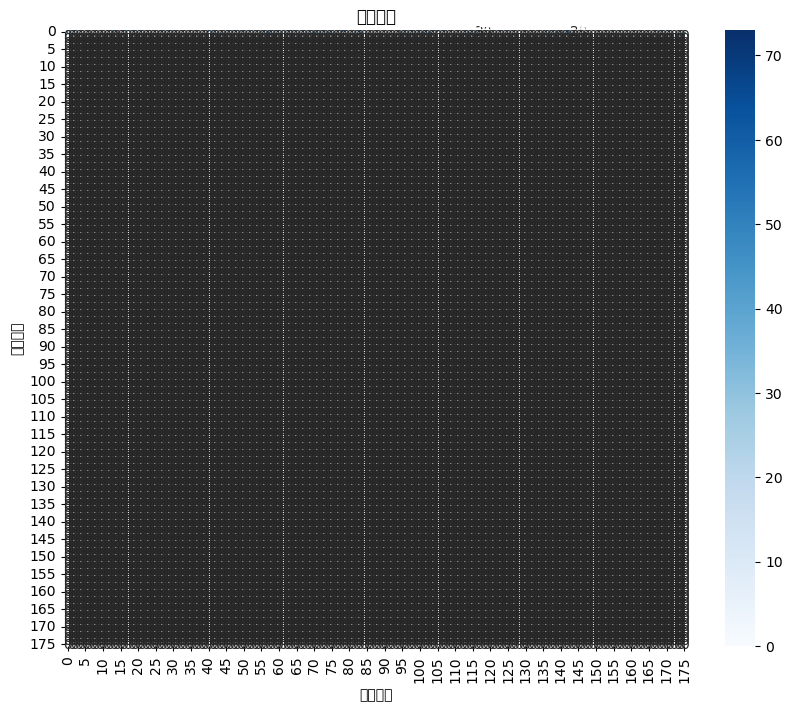

In [137]:
#完成函数模型的评估
# 第14步：评估函数
def evaluate_model(model, data_loader, class_names=None):
    """评估模型性能"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    predictions, true_labels = predict(model, data_loader, device)
    
    # 分类报告
    if class_names:
        target_names = [class_names[i] for i in range(len(class_names))]
        print(classification_report(true_labels, predictions, target_names=target_names))
    else:
        print(classification_report(true_labels, predictions))
    
    # 混淆矩阵
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('混淆矩阵')
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.show()

print("评估函数定义完成")

evaluate_model(model, test_loader, class_names=idx_to_label)